<a href="https://colab.research.google.com/github/Joyschool/2024_mirae_master/blob/main/3%EC%9D%BC%EC%B0%A8_%EC%9B%B9%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%88%98%EC%A7%91%EB%B0%8F%EC%8B%9C%EA%B0%81%ED%99%94_OpenAPI_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 웹 데이터 수집 및 시각화

## 2. OpenAPI를 이용한 데이터 수집

- <a href="#1)OpenAP를이용한데이터수집">1) OpenAPI를 이용한 데이터 수집</a>
- <a href="#2)뉴스데이터워드클라우드만들기">2) 뉴스데이터 워드클라우드 만들기</a>
- <a href="#3)웹이미지수집하기">3) 웹 이미지 수집하기</a>

### #그래프에서 한글사용하는 방법
- **(코랩에서)한글폰트 설치하기**

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 코랩에서 위 코드를 실행시킨 후  반드시 코랩 메뉴: "런타임>런타임 다시 시작" 합니다.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (14.6 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123623 files and direc

- **한글 폰트 지정하기**

In [1]:
# 코랩에서 한글 폰트 종류와 이름이 win과 다를 수 있다!!!
# 코랩: NanumGothic, 윈도우: Malgun Gothic
import matplotlib.pyplot as plt
plt.rcParams.update({'font.family': 'NanumGothic',
                     'font.size': 12,
                     'figure.figsize': (6, 4),
                     'axes.unicode_minus':  False }) # 폰트 설정

---

### <a name="1)OpenAP를이용한데이터수집">1) OpenAPI를 이용한 데이터 수집</a>

#### 1.네이버 OpenAPI 신청하기
* 네이버 검색(책, 뉴스, 쇼핑)
    - 네이버 OpenAPI 소개: https://developers.naver.com/products/intro/plan/
    - 개발 가이드 보기: https://developers.naver.com/docs/serviceapi/search/news
    - OpenAPI 신청하기: https://developers.naver.com/apps/#/register

#### 2.네이버 OpenAPI 사용하기
* 검색
    - 1.책 검색
    - 2.뉴스 검색
    - 3.쇼핑 검색

#### [실습] : 네이버 검색 API 사용하여 데이터 수집하기

In [4]:
import os
import sys
import urllib.request
import datetime
import time
import json
import pandas as pd

now = datetime.datetime.now()
datas = []   #csv파일을 위한 변수

client_id = 'tTOLdXAqAYZvjbvnJigb'  # 자신의 client_id
client_pw = 'P0v7lfXcIS'            # 자신의 client_secret


#[CODE 1]
def get_RequestUrl(url):
    req = urllib.request.Request(url)
    req.add_header("X-Naver-Client-Id", client_id)
    req.add_header("X-Naver-Client-Secret", client_pw)

    try:
        response = urllib.request.urlopen(req)
        if response.getcode() == 200:
            print(f"[{now.strftime('%Y년%m월%d일 %H시%M분%S초')}] Url Request Success")
            return response.read().decode('utf-8')

    except Exception as e:
#         if response.getcode() == 400 and datas:
#             return None
        print(e)
        print(f"[{now.strftime('%Y년%m월%d일 %H시%M분%S초')}] Error for URL : {url}" )
        return None


#[CODE 2]  네이버 검색 API
def get_NaverSearch(node, keyword, start, display):
    base = "https://openapi.naver.com/v1/search"
    node = "/%s.json" % node
    parameters = "?query=%s&start=%s&display=%s" % (urllib.parse.quote(keyword), start, display)

    url = base + node + parameters
    responseDecode = get_RequestUrl(url)   #[CODE 1]

    if (responseDecode == None):
        return None
    else:
        return json.loads(responseDecode)

#[CODE 3]
def get_PostData(node, post, jsonResult, cnt):
    if node == 'book':
        data = {'제목':post['title'],
                '저자':post['author'],
                '출판사':post['publisher'],
                '출간일':post['pubdate'],
                '링크':post['link'],
                '이미지':post['image']}
    elif node == 'news':
        data = {'제목':post['title'],
                '링크':post['originallink'],
                '내용':post['description']}
    elif node == 'shop':
        data = {'제목':post['title'],
                '브랜드':post['brand'],
                '제조사':post['maker'],
                '가격':post['lprice'],
                '이미지':post['image']}

    jsonResult.append(data)
    datas.append(data)

    return

#[CODE 0]
def main():
    global node, keyword

    nodeType = '''수집할 대상 입니다.\n 1.book,  2.news,  3.shop'''
    print('-'*30)
    print(nodeType)
    print('-'*30)
    node = input('번호를 선택하세요.[1:책, 2:뉴스, 3:쇼핑]')
    if node == '1': node = 'book'
    elif node == '2': node = 'news'
    elif node == '3': node = 'shop'
    else:
        node == '1'
        node = 'book'

    keyword = input(f'{node} 검색할 검색어를 입력하세요: ')
    print('-'*30)

    display, cnt = 100, 0
    jsonResult = []
    jsonResponse = get_NaverSearch(node, keyword, 1, display)  #[CODE 2]
    total = jsonResponse['total']

    while ((jsonResponse != None) and (jsonResponse['display'] != 0)):
        for post in jsonResponse['items']:
            cnt += 1
            get_PostData(node, post, jsonResult, cnt)  #[CODE 3]

        start = jsonResponse['start'] + jsonResponse['display']
        jsonResponse = get_NaverSearch(node, keyword, start, total)
#     print(f'가져올 데이터 : {total} 건')

    # with open(f'naver_{node}_{keyword}', 'w', encoding='utf8') as outfile:
    #     jsonFile = json.dumps(jsonResult,  indent=4, sort_keys=True,  ensure_ascii=False)

    #     outfile.write(jsonFile)

    print("가져온 데이터 : %d 건" %(cnt))



    # csv 파일로 저장하기
    file = f'naver_{node}_{keyword}.csv'
    df = pd.DataFrame(datas)
    df.to_csv(file, index=False, encoding="utf-8-sig")
    print(f'naver_{node}_{keyword}.csv SAVED')
    return df

#-----------
# 시작
#-----------
df = main()
df.head()

------------------------------
수집할 대상 입니다.
 1.book,  2.news,  3.shop
------------------------------
번호를 선택하세요.[1:책, 2:뉴스, 3:쇼핑]3
shop 검색할 검색어를 입력하세요: 여성니트
------------------------------
[2024년10월30일 07시53분32초] Url Request Success
HTTP Error 400: Bad Request
[2024년10월30일 07시53분32초] Error for URL : https://openapi.naver.com/v1/search/shop.json?query=%EC%97%AC%EC%84%B1%EB%8B%88%ED%8A%B8&start=101&display=17032975
가져온 데이터 : 100 건
naver_shop_여성니트.csv SAVED


,제목,브랜드,제조사,가격,이미지
0,루즈핏 브이넥 <b>니트</b>,,,26790,https://shopping-phinf.pstatic.net/main_504234...
1,루즈핏 울 캐시미어니트 라운드 브이넥니트 가을 겨울 <b>여성니트</b>티 아이보리...,,,18500,https://shopping-phinf.pstatic.net/main_820167...
2,부드러운 기본 블랙 핑크 26컬러 가을 데일리 캐시미어 니트 라운드 <b>여성 니트...,,,18500,https://shopping-phinf.pstatic.net/main_811054...
3,루즈핏 반목폴라 캐시미어니트 가을 겨울 <b>여성 니트</b>티 반폴라 목폴라 니트...,,,19800,https://shopping-phinf.pstatic.net/main_822705...
4,부드러운 루즈핏 울 캐시미어니트 라운드 브이넥니트 가을 겨울 <b>여성니트</b>티...,,,18500,https://shopping-phinf.pstatic.net/main_833952...




---



### [실습] 수집된 데이터 분석하기(책)

#### Q1.수집된 [책] 데이터에서 저자가 '한강'인 도서만 출력하세요.

- Q1. 컬럼 목록

- Q2. 저자 컬럼의 고유한 값과 빈도수

- Q3. 저자가 '한강'인 도서 출력

- Q4.'한강' 저자의 최근 작품 정보(출간일, 책제목, 출판사 등)

- Q5.'한강' 저자의 최초 작품 정보(출간일, 책제목, 출판사 등)

-------------------------

### <a name="2))뉴스데이터워드클라우드만들기">2) 뉴스데이터 워드클라우드 만들기</a>

#### 1.라이브러리 설치

In [5]:
# 자연어처리 형태소 분석 및 토큰화
!pip install nltk

In [6]:
# (한글)자연어처리 형태소 분석 및 토큰화
# (WinOS에서는 konlpy를 사용하기 위해 JDK를 설치해야 오류가 없어 코랩에서 실행함)
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 21.9 MB/s eta 0:00:00


In [ ]:
# html tag parsing을 위한 라이브러리
!pip install beautifulsoup4

In [ ]:
# 사이킷런 CountVectorizer클래스 사용 : 단어 빈도수 추출
!pip install scikit-learn

#### 2.한글 테스트 자연어 처리(Text Cleansing)
- 앞에서 OpenAPI를 사용하여 뉴스 데이터를 가져온 뒤에 아래 코드를 실행시키도록 한다.


In [8]:
import pandas as pd
import re
from bs4 import BeautifulSoup
import konlpy
import nltk

def clean_korean_documents(documents):
    #텍스트 정제 (HTML 태그 제거)
    for i, document in enumerate(documents):
        document = BeautifulSoup(document, 'html.parser').text
        documents[i] = document

    #텍스트 정제 (특수기호 제거)
    for i, document in enumerate(documents):
        document = re.sub(r'[^ ㄱ-ㅣ가-힣]', '', document) #특수기호 제거, 정규 표현식
        documents[i] = document

    #텍스트 정제 (형태소 분석)
    for i, document in enumerate(documents):
        okt = konlpy.tag.Okt()
        clean_words = []
        for word in okt.pos(document, stem=True): #어간 추출
            if word[1] in ['Noun', 'Verb', 'Adjective']: #명사, 동사, 형용사
                clean_words.append(word[0])
        document = ' '.join(clean_words)
        documents[i] = document

    #텍스트 정제 (불용어 제거)
    df = pd.read_csv('https://raw.githubusercontent.com/cranberryai/todak_todak_python/master/machine_learning_text/clean_korean_documents/korean_stopwords.txt', header=None)
    df[0] = df[0].apply(lambda x: x.strip())
    stopwords = df[0].to_numpy()
    nltk.download('punkt')
    for i, document in enumerate(documents):
        clean_words = []
        for word in nltk.tokenize.word_tokenize(document):
            if word not in stopwords: #불용어 제거
                clean_words.append(word)
        documents[i] = ' '.join(clean_words)

    return documents


def clean_target_feature(data):
    x_data = data.to_list()
    return clean_korean_documents(x_data)



# ---------------------
# 1.클린징할 파일 가져오기
# 앞에서 저장한 뉴스 데이터 파일 이름
file = 'naver_news_노벨상.csv'  # 앞에서 만들어진 파일 사용하기
df = pd.read_csv(file)

# 2.클린징할 컬럼 선택해서 클린징하기
# (앞 OpenAPI검색에서 2.news 검색을 한 후 실행하기)
df['제목'] = clean_target_feature(df['제목'])  # 기사 제목
df['내용'] = clean_target_feature(df['내용'])  # 기사 내용

# 3.클린징 결과 csv 파일로 저장하기
file = 'naver_news_노벨상.csv'
df.to_csv(file, index=False, encoding="utf-8-sig")
print(f'{file} SAVED')

df.head()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-8-78faa3529469>:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  document = BeautifulSoup(document, 'html.parser').text


naver_news_노벨상.csv SAVED


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,제목,링크,내용
0,부산시 도서관 한강 작가 도서 전시 계 행사 성,http://www.bzeronews.com/news/articleView.html...,한강 작가 노벨상 수상 기념 주요 계 행사 시민 도서관 저서 분석 특강 한강 이야기...
1,논단 노벨문학상 정원 도시 성공 방정식,http://www.lak.co.kr?id=18604,젠 노벨상 수상작 어로 읽다 열 오르다 객쩍 문화 자긍심 덩달아 들썩이다 어쩌면 노...
2,마콜 컨설팅 그룹 새 경영 컨설팅 방법론 제시 시스템스 퍼블릭 어페,https://www.seoul.co.kr/news/economy/2024/10/3...,옥스포드 대학 사이드 경영 대학원 의 학장 지내다 하다 저명 경영학자 콜린 메이어 ...
3,마콜 컨설팅 그룹 시스템스 퍼블릭 어페어즈 발표,https://view.asiae.co.kr/article/2024103015532...,옥스포드 대학 사이드 경영 대학원 의 학장 지내다 하다 저명 경영학자 콜린 메이어 ...
4,고양 독서 대전 료,https://www.joongdo.co.kr/web/view.php?key=202...,한강 작가 노벨상 수상 기념 하다 한강 작가 작품 전과 해외 문학상 수상한 국문학 ...


#### 3.워드 클라우드 만들기

[('한강', 39), ('노벨상', 30), ('작가', 26), ('기념', 15), ('강연', 14), ('기록관', 13), ('특별', 13), ('되다', 9), ('컨설팅', 9), ('광주', 7)]


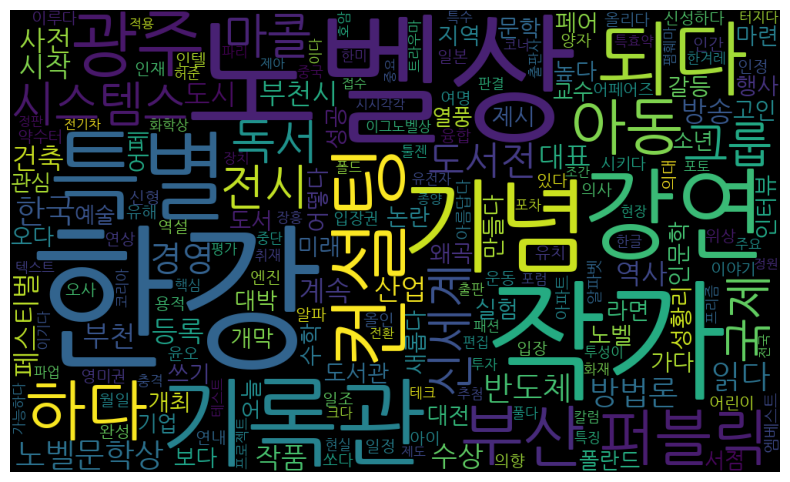

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,6)

# 말뭉치를 토큰화하여 빈도수 가져오기
def get_wordTokenCount(corpus):
    from sklearn.feature_extraction.text import CountVectorizer

    # 말뭉치를 토큰화하기
    vect = CountVectorizer().fit(corpus)
    count = vect.transform(corpus).toarray().sum(axis=0)

    # 토큰 빈도수로 정렬하고 토큰명 추출
    idx = np.argsort(-count)  # 내림 정렬하여 인덱스 반환: 토큰의 인덱스
    count = count[idx]        # 토큰의 빈도수
    feature_name = np.array(vect.get_feature_names_out())[idx]  # 토큰값

    # 빈도수 많은 순서대로 토큰명 10개만 출력
    print(list(zip(feature_name, count))[:10])

    return feature_name, count


# 단어(토큰) 빈도수 막대 그래프 그리기
def draw_wordTokenCountGraph(data, freq):
    plt.bar(data, freq)
    plt.grid()
    plt.show()

    # 그래프 그림 저장히기
    plt.savefig(f'./token_bar_graph.png')

# 워드클라우드 만들기
def make_wordcloud(feature_name, count):
    # 한글 폰트 경로를 설정
    # font_path = 'NanumGothic'  #/usr/share/fonts/truetype/nanum/NanumGothic.ttf  #코랩
    font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  #/usr/share/fonts/truetype/nanum/NanumGothic.ttf  #코랩

    # (토큰명, 빈도수) 딕셔너리 타입으로 변환
    data = dict(zip(feature_name, count))

    # 워드클라우드로 그래프로 시각화
    wc = WordCloud(width = 1000, height = 600, background_color="black", font_path=font_path)
    plt.imshow(wc.generate_from_frequencies(data)) #딕셔너리
    plt.axis("off")
    plt.show()

    # 이미지 파일로 저장하기
    wc.to_file(f'워드클라우드.png')


# 0.앞에서 클린징한 파일 사용하기
df = pd.read_csv('naver_news_노벨상.csv')

# 1.텍스트 말뭉치(corpus) 데이터 지정하기
corpus = df['제목'].to_list()
# print(corpus)

# 2.말뭉치를 토큰화하여 빈도수 가져오기
feature_name, count = get_wordTokenCount(corpus)

# 3.단어(토큰) 빈도수 막대 그래프 그리기(상위 10개)
# draw_wordTokenCountGraph(feature_name[:10], count[:10])

# 3.워드 클라우드 만들기
make_wordcloud(feature_name, count)



---



### <a name="3)웹이미지수집하기">3) 웹 이미지 수집하기</a>

In [10]:
df = pd.read_csv('naver_shop_여성니트.csv')
df.head(5)

,제목,브랜드,제조사,가격,이미지
0,루즈핏 브이넥 <b>니트</b>,NaN,NaN,26790,https://shopping-phinf.pstatic.net/main_504234...
1,루즈핏 울 캐시미어니트 라운드 브이넥니트 가을 겨울 <b>여성니트</b>티 아이보리...,NaN,NaN,18500,https://shopping-phinf.pstatic.net/main_820167...
2,부드러운 기본 블랙 핑크 26컬러 가을 데일리 캐시미어 니트 라운드 <b>여성 니트...,NaN,NaN,18500,https://shopping-phinf.pstatic.net/main_811054...
3,루즈핏 반목폴라 캐시미어니트 가을 겨울 <b>여성 니트</b>티 반폴라 목폴라 니트...,NaN,NaN,19800,https://shopping-phinf.pstatic.net/main_822705...
4,부드러운 루즈핏 울 캐시미어니트 라운드 브이넥니트 가을 겨울 <b>여성니트</b>티...,NaN,NaN,18500,https://shopping-phinf.pstatic.net/main_833952...


#### 1.웹 이미지 화면에 출력하기

In [11]:
from IPython.display import Image
Image(url='https://shopping-phinf.pstatic.net/main_8201676/82016764964.17.jpg')

#### 2.웹 이미지 파일로 저장하기

In [12]:
import requests
from io import BytesIO
from PIL import Image

# 다운받을 이미지 url
urls = [
    "https://shopping-phinf.pstatic.net/main_8201676/82016764964.17.jpg",
    "https://shopping-phinf.pstatic.net/main_8339525/83395253385.13.jpg"
]
# 파일로 저장하기
for idx, url in enumerate(urls):
    res = requests.get(url)                   # url 요청
    img = Image.open(BytesIO(res.content))    # 응답결과(res.content)바이트파일 이미지 파일로 오픈
    img.save(f'./testimg_{idx}.png', 'png')   # 'png'이미지로(만) 저장

#### [실습] : 웹 이미지 수집하기
- 앞에서 저장한 쇼핑 목록에 있는 URL을 이용하여 이미지 저장하기

In [13]:
# 이미지 다운로드 하기
import pandas as pd
import requests
from io import BytesIO
from PIL import Image
import time
import os


def getImageUrl(file):
    print(f'읽은 파일명: {file}')
    df = pd.read_csv(file, encoding='utf-8') # 이미지가 있는 쇼핑 파일 불러오기
    return df['이미지'].to_list()

def createDirectory(directory): # 다운받을 이미지 폴더 만들기
    try:
        if not os.path.exists(directory):
            print(f'{directory} 폴더가 생성되었습니다.')
            os.makedirs(directory)
        print(f'이미지 폴더 위치 : {directory}')
    except OSError:
        print("Error: Failed to create the directory.")

def downloadImageFile(urls, imgfolder):
    start = time.time()             # 이미지 다운로드 속도 time check
    for idx, url in enumerate(urls):
        if idx == MAX:
            break  # MAX 건수만 처리하기
        res = requests.get(url)     # request.get 요청
#         print(f'[{idx+1:2>}][{time.time() - start}] : {url}')  # 이미지 다운로드 시간 체크
        print(f'[{idx+1:0>2}] : {url}')  # 이미지 다운로드 시간 체크
        img = Image.open(BytesIO(res.content))  #Img open
        img.save(f'{imgfolder}testimage_{idx}.png', 'png')
    return idx


# 자신에게 맞게 폴더/파일 위치 정보를 수정한다.
shop_image = 'naver_shop_여성니트.csv'  # 앞에서 자신이 검색한 쇼핑 파일
image_folder = './image_download/'      # 다운받을 이미지 폴더
MAX = 10                              # 이미지 파일 다운로드 건수

# 이미지 다운로드 하기
urls = getImageUrl(shop_image)                # 이미지 URL 목록 가져오기
createDirectory(image_folder)              # 다운받을 이미지 폴더 만들기
totalcnt = downloadImageFile(urls, image_folder)      # 이미지 다운로드하기
print(f'총 다운로드 건수: {totalcnt}')


읽은 파일명: naver_shop_여성니트.csv
./image_download/ 폴더가 생성되었습니다.
이미지 폴더 위치 : ./image_download/
[01] : https://shopping-phinf.pstatic.net/main_5042341/50423416880.20240922125247.jpg
[02] : https://shopping-phinf.pstatic.net/main_8201676/82016764964.17.jpg
[03] : https://shopping-phinf.pstatic.net/main_8110549/81105494642.6.jpg
[04] : https://shopping-phinf.pstatic.net/main_8227052/82270521487.3.jpg
[05] : https://shopping-phinf.pstatic.net/main_8339525/83395253385.13.jpg
[06] : https://shopping-phinf.pstatic.net/main_5061093/50610938882.20241015172839.jpg
[07] : https://shopping-phinf.pstatic.net/main_5046220/50462207668.20240925000229.jpg
[08] : https://shopping-phinf.pstatic.net/main_5077735/50777354058.20241010170520.jpg
[09] : https://shopping-phinf.pstatic.net/main_5050333/50503330059.20240927024536.jpg
[10] : https://shopping-phinf.pstatic.net/main_8679458/86794581238.3.jpg
총 다운로드 건수: 10


---------------------------

끝!